# SCC-ICMC-USP - 2º Semestre de 2025
### SCC0634 - Aplicações de Inteligência Artificial
### Trabalho Semestral

### **Clusterização de dados socioeconômicos do Enem de 2023 na região sudeste**

**Alunos:**
1. Lucas Lombardi Castro, 13672978 (turma de segunda-feira)
2. Lucas Piovani Ferreira, 13836813 (turma de terça-feira)

---

## Sumário
1. [Imports](#imports)
2. [Introdução](#intro)
3. [Objetivos](#objetivos)
4. [Análise Exploratória de Dados](#aed)
    1. [Análise das Notas](#analise_notas)
    2. [Variáveis Socioeconômicas](#socioeconomica)
        1. [Distribuição por Sexo](#sex-distribution)
        2. [Distribuição socioeconômica por nota média](#socio_media)
        3. [Relação escola pública/privada e desempenho](#tipo_escola)
    3. [Matriz de Correlação](#correlacao-matriz)
5. [Pré-processamento](#data-preprocessing)
    1. [Verificação de valores faltantes](#missing-values)
    2. [Tratamento de valores ordinais (Q001-Q025)](#tratar-questionario)
    3. [Encoding de variáveis categóricas](#encoding)
    4. [Normalizando a escala](#standard-scaler)
6. [Modelagem](#modeling)
    1. [Redução de dimensionalidade (PCA)](#pca)
    2. [Clusterização 1: DBSCAN](#dbscan)
        1. [Método do cotovelo (*eps*)](#elbow-method-eps)
        2. [Treinamento](#training-dbscan)
        3. [Avaliação dos clusters](#evaluation-dbscan)
    3. [Clusterização 2: K-Means](#kmeans)
        1. [Método do cotovelo (*K*)](#elbow-method-k)
        2. [Treinamento](#training-kmeans)
        3. [Avaliação dos clusters](#evaluation-kmeans)
7. [Aplicação: RAG](#rag)
    1. [Instalação de dependências](#dependencias)
    2. [Iniciando o RAG com Ollama](#ollama)
    3. [Perguntando ao RAG](#perguntas)
8. [Conclusões](#conclusoes)

---

### 1. Imports <a id="imports"></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import string
import os
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans

---

### 2. Introdução <a id="intro"></a>

A educação é um dos pilares centrais para o desenvolvimento social e econômico de um país, e compreender os fatores que influenciam o desempenho estudantil é essencial para embasar políticas públicas eficazes. O Exame Nacional do Ensino Médio (ENEM), aplicado anualmente no Brasil, reúne um dos maiores bancos de dados educacionais do mundo, contendo informações acadêmicas, socioeconômicas e demográficas de milhões de candidatos. Esses dados oferecem uma oportunidade valiosa para investigar padrões e desigualdades no acesso à educação e nos resultados obtidos pelos estudantes.

Neste projeto, analisaremos os dados do ENEM 2023 com foco na identificação de perfis de candidatos da região sudeste por meio de técnicas de agrupamento, como o algoritmo DBSCAN e K-Means. A clusterização permitirá explorar semelhanças entre os estudantes considerando suas notas, características socioeconômicas e informações escolares, possibilitando a descoberta de grupos com padrões comuns de desempenho e contexto social. A análise terá como objetivo não apenas delimitar esses grupos, mas investigar como se diferenciam entre si e o que esses resultados indicam sobre a realidade educacional brasileira.

Após a etapa de agrupamento, será construída uma aplicação baseada em Recuperação Aumentada por Geração (RAG), utilizando modelos de linguagem para permitir que usuários consultem os clusters de forma intuitiva. Assim, em vez de acessarem tabelas ou relatórios técnicos, professores, pesquisadores e formuladores de políticas públicas poderão fazer perguntas em linguagem natural, como “quais características sociais estão associadas ao cluster com maior desempenho?”, e receber respostas contextuais com base nos dados analisados. Dessa forma, o projeto une ciência de dados e inteligência artificial para promover transparência e acessibilidade na compreensão dos resultados educacionais.

---

### 3. Objetivos <a id="objetivos"></a>

O objetivo deste projeto é analisar os microdados do ENEM 2023 para identificar perfis distintos de candidatos por meio de técnicas de clusterização, visando gerar conhecimento acessível e útil para a compreensão do desempenho estudantil na região sudeste. Para isso, busca-se: 

(i) realizar uma exploração detalhada do conjunto de dados, mapeando padrões socioeconômicos, acadêmicos e demográficos;

(ii) aplicar o algoritmo DBSCAN e K-Means para agrupar candidatos com características semelhantes e caracterizar os perfis encontrados;

(iii) interpretar os clusters com o intuito de revelar desigualdades educacionais e tendências relevantes para políticas públicas;

(iv) desenvolver uma aplicação baseada em Recuperação Aumentada por Geração (RAG) para que usuários consultem os resultados dos agrupamentos em linguagem natural, democratizando o acesso aos insights extraídos.

---

### 4. Análise Exploratória de Dados <a id="aed"></a>

In [2]:
df = pd.read_csv("input_clustering/MICRODADOS_ENEM_SUDESTE_2023.csv")
df.head()

,TP_FAIXA_ETARIA,TP_SEXO,TP_ESTADO_CIVIL,TP_COR_RACA,TP_NACIONALIDADE,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,TP_ENSINO,IN_TREINEIRO,...,Q016,Q017,Q018,Q019,Q020,Q021,Q022,Q023,Q024,Q025
0,3,M,1,1,1,2,0,2,1.0,0,...,A,A,A,B,A,A,B,A,A,B
1,3,M,1,2,1,2,0,2,1.0,0,...,B,A,A,D,A,A,D,A,B,B
2,2,F,0,2,2,2,0,2,1.0,0,...,B,A,A,B,A,A,A,A,A,B
3,2,M,1,3,1,2,0,2,1.0,0,...,B,A,B,B,A,A,C,A,B,B
4,2,F,1,0,1,2,0,2,1.0,0,...,A,A,A,B,A,A,A,A,A,A


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 259328 entries, 0 to 259327
Data columns (total 65 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   TP_FAIXA_ETARIA         259328 non-null  int64  
 1   TP_SEXO                 259328 non-null  object 
 2   TP_ESTADO_CIVIL         259328 non-null  int64  
 3   TP_COR_RACA             259328 non-null  int64  
 4   TP_NACIONALIDADE        259328 non-null  int64  
 5   TP_ST_CONCLUSAO         259328 non-null  int64  
 6   TP_ANO_CONCLUIU         259328 non-null  int64  
 7   TP_ESCOLA               259328 non-null  int64  
 8   TP_ENSINO               255896 non-null  float64
 9   IN_TREINEIRO            259328 non-null  int64  
 10  CO_MUNICIPIO_ESC        259328 non-null  float64
 11  NO_MUNICIPIO_ESC        259328 non-null  object 
 12  CO_UF_ESC               259328 non-null  float64
 13  SG_UF_ESC               259328 non-null  object 
 14  TP_DEPENDENCIA_ADM_E

A inspeção inicial do dataframe revelou um conjunto de dados extremamente robusto, contendo 259.328 registros distribuídos em 65 variáveis, que englobam informações demográficas, socioeconômicas, acadêmicas e de desempenho dos participantes do ENEM 2023 na região sudeste.

Observa-se uma combinação de tipos numéricos, majoritariamente relacionados a notas, presença nas provas e códigos administrativos, e variáveis categóricas (object), principalmente relativas ao perfil socioeconômico (Q001–Q025) e dados de identificação escolar e geográfica.

Observe a descrição de cada coluna e seu tipo de dado:

| Colunas | Tipo | Significado |
|--------|------|-------------|
| TP_FAIXA_ETARIA | int64 | Faixa etária do participante |
| TP_SEXO | object | Sexo do participante |
| TP_ESTADO_CIVIL | int64 | Estado civil |
| TP_COR_RACA | int64 | Cor/raça declarada |
| TP_NACIONALIDADE | int64 | Nacionalidade |
| TP_ST_CONCLUSAO | int64 | Status de conclusão do Ensino Médio |
| TP_ANO_CONCLUIU | int64 | Ano em que concluiu o Ensino Médio |
| TP_ESCOLA | int64 | Tipo de escola em que estudou |
| TP_ENSINO | float64 | Modalidade de ensino médio |
| IN_TREINEIRO | int64 | Indica se o participante fez a prova como treineiro |
| CO_MUNICIPIO_ESC, NO_MUNICIPIO_ESC | float64 / object | Código e nome do município da escola |
| CO_UF_ESC, SG_UF_ESC | float64 / object | Código e sigla da UF da escola |
| TP_DEPENDENCIA_ADM_ESC | float64 | Dependência administrativa da escola |
| TP_LOCALIZACAO_ESC | float64 | Localização da escola |
| TP_SIT_FUNC_ESC | float64 | Situação de funcionamento da escola |
| CO_MUNICIPIO_PROVA, CO_UF_PROVA, SG_UF_PROVA | int64 / object | Local onde o participante realizou a prova |
| TP_PRESENCA_CN / CH / LC / MT | int64 | Presença nas provas de CN, CH, LC e MT |
| CO_PROVA_CN / CH / LC / MT | float64 | Código da prova aplicada |
| NU_NOTA_CN / CH / LC / MT | float64 | Nota obtida nas provas objetivas |
| TP_LINGUA | int64 | Língua estrangeira escolhida |
| TP_STATUS_REDACAO | float64 | Status da redação (ex.: anulada, completa) |
| NU_NOTA_COMP1 — NU_NOTA_COMP5 | float64 | Pontuações dos cinco critérios da redação |
| NU_NOTA_REDACAO | float64 | Nota final da redação |
| Q001 — Q025 | object | Variáveis de questionário socioeconômico |

In [4]:
statistics = df.describe()
statistics

,TP_FAIXA_ETARIA,TP_ESTADO_CIVIL,TP_COR_RACA,TP_NACIONALIDADE,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,TP_ENSINO,IN_TREINEIRO,CO_MUNICIPIO_ESC,...,NU_NOTA_MT,TP_LINGUA,TP_STATUS_REDACAO,NU_NOTA_COMP1,NU_NOTA_COMP2,NU_NOTA_COMP3,NU_NOTA_COMP4,NU_NOTA_COMP5,NU_NOTA_REDACAO,Q005
count,259328.000000,259328.000000,259328.000000,259328.000000,259328.0,259328.0,259328.000000,255896.000000,259328.0,2.593280e+05,...,259328.000000,259328.000000,259328.000000,259328.000000,259328.000000,259328.000000,259328.000000,259328.000000,259328.000000,259328.000000
mean,2.720466,0.991975,1.695675,1.028092,2.0,0.0,2.363274,1.003150,0.0,3.389054e+06,...,578.485921,0.235890,1.079961,129.010905,150.315816,127.772936,138.811235,122.863478,668.774371,3.723771
std,0.993932,0.253084,0.949302,0.231953,0.0,0.0,0.480944,0.056034,0.0,1.690472e+05,...,130.555150,0.424555,0.585408,31.011457,46.745627,39.603795,40.087589,58.339768,194.195136,1.112827
min,1.000000,0.000000,0.000000,0.000000,2.0,0.0,2.000000,1.000000,0.0,3.100104e+06,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,1.000000,1.000000,1.000000,2.0,0.0,2.000000,1.000000,0.0,3.205200e+06,...,480.100000,0.000000,1.000000,120.000000,120.000000,120.000000,120.000000,80.000000,560.000000,3.000000
50%,3.000000,1.000000,1.000000,1.000000,2.0,0.0,2.000000,1.000000,0.0,3.506508e+06,...,583.700000,0.000000,1.000000,120.000000,160.000000,120.000000,140.000000,120.000000,680.000000,4.000000
75%,3.000000,1.000000,3.000000,1.000000,2.0,0.0,3.000000,1.000000,0.0,3.547304e+06,...,675.300000,0.000000,1.000000,160.000000,200.000000,160.000000,160.000000,180.000000,820.000000,4.000000
max,20.000000,4.000000,5.000000,4.000000,2.0,0.0,3.000000,2.000000,0.0,3.557303e+06,...,958.600000,1.000000,9.000000,200.000000,200.000000,200.000000,200.000000,200.000000,1000.000000,20.000000


A análise estatística revela um conjunto de dados robusto com 259.328 registros e um perfil extremamente homogêneo em relação à situação escolar. Observa-se que o desvio padrão (std) é zero para as variáveis TP_ST_CONCLUSAO (Situação de conclusão), TP_ANO_CONCLUIU e IN_TREINEIRO, ou seja, o dataset contém apenas candidatos que não são treineiros e que estão no mesmo estágio de conclusão do ensino médio. A faixa etária (TP_FAIXA_ETARIA) confirma esse cenário, com uma mediana de 3 e quartis estreitos (2 a 3), caracterizando um público majoritariamente jovem, típico de vestibulandos recém-saídos da escola.

No quesito desempenho, os estudantes da região Sudeste apresentam indicadores elevados, especialmente na Redação. A média geral da NU_NOTA_REDACAO é de aproximadamente 669 pontos, com a mediana em 680, o que sugere um domínio competente da escrita para a maioria dos candidatos. Ao detalhar as competências, nota-se que o ponto mais forte é a estrutura e o tema (COMP2, média ~150), enquanto a maior dificuldade reside na proposta de intervenção (COMP5, média ~123). Já em Matemática (NU_NOTA_MT), embora a média gire em torno de 578 pontos, há uma amplitude notável, com a nota máxima chegando a 958,6, evidenciando a existência de alunos de altíssima performance (outliers positivos) neste grupo.

In [5]:
# Verificando a porcentagem de valores nulos em cada coluna
df_nulls = (df.isna().mean() * 100).sort_values(ascending=False)
df_nulls[df_nulls > 0]

TP_ENSINO    1.323421
dtype: float64

#### 4.1. Análise das Notas <a id="analise_notas"></a>

In [6]:
nota_cols = [
    'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT', 'NU_NOTA_REDACAO'
]

df[nota_cols].describe()

,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT,NU_NOTA_REDACAO
count,259328.000000,259328.000000,259328.000000,259328.000000,259328.000000
mean,515.082437,546.376155,539.825238,578.485921,668.774371
std,86.032909,80.968626,67.643503,130.555150,194.195136
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,459.700000,499.700000,499.700000,480.100000,560.000000
50%,516.200000,554.000000,545.200000,583.700000,680.000000
75%,569.800000,602.000000,586.500000,675.300000,820.000000
max,856.700000,823.000000,791.400000,958.600000,1000.000000


A Redação e a Matemática consolidam-se como os maiores diferenciais competitivos do exame. A Redação lidera com a maior média global (668,8) e alcance da nota máxima (1000), enquanto a Matemática, apesar de uma média inferior (578,5), apresenta o maior teto entre as provas objetivas (958,6), permitindo aos candidatos de alto desempenho se destacarem drasticamente da concorrência.

Por outro lado, os dados revelam grande disparidade e dificuldade específica. A Redação possui o maior desvio padrão (~194), indicando níveis de domínio extremamente desiguais entre os alunos. Já Ciências da Natureza figura como a prova mais difícil, com a menor média do conjunto (515,1), e Linguagens apresenta a menor variabilidade, sugerindo uma concentração de notas em um patamar mediano difícil de superar.

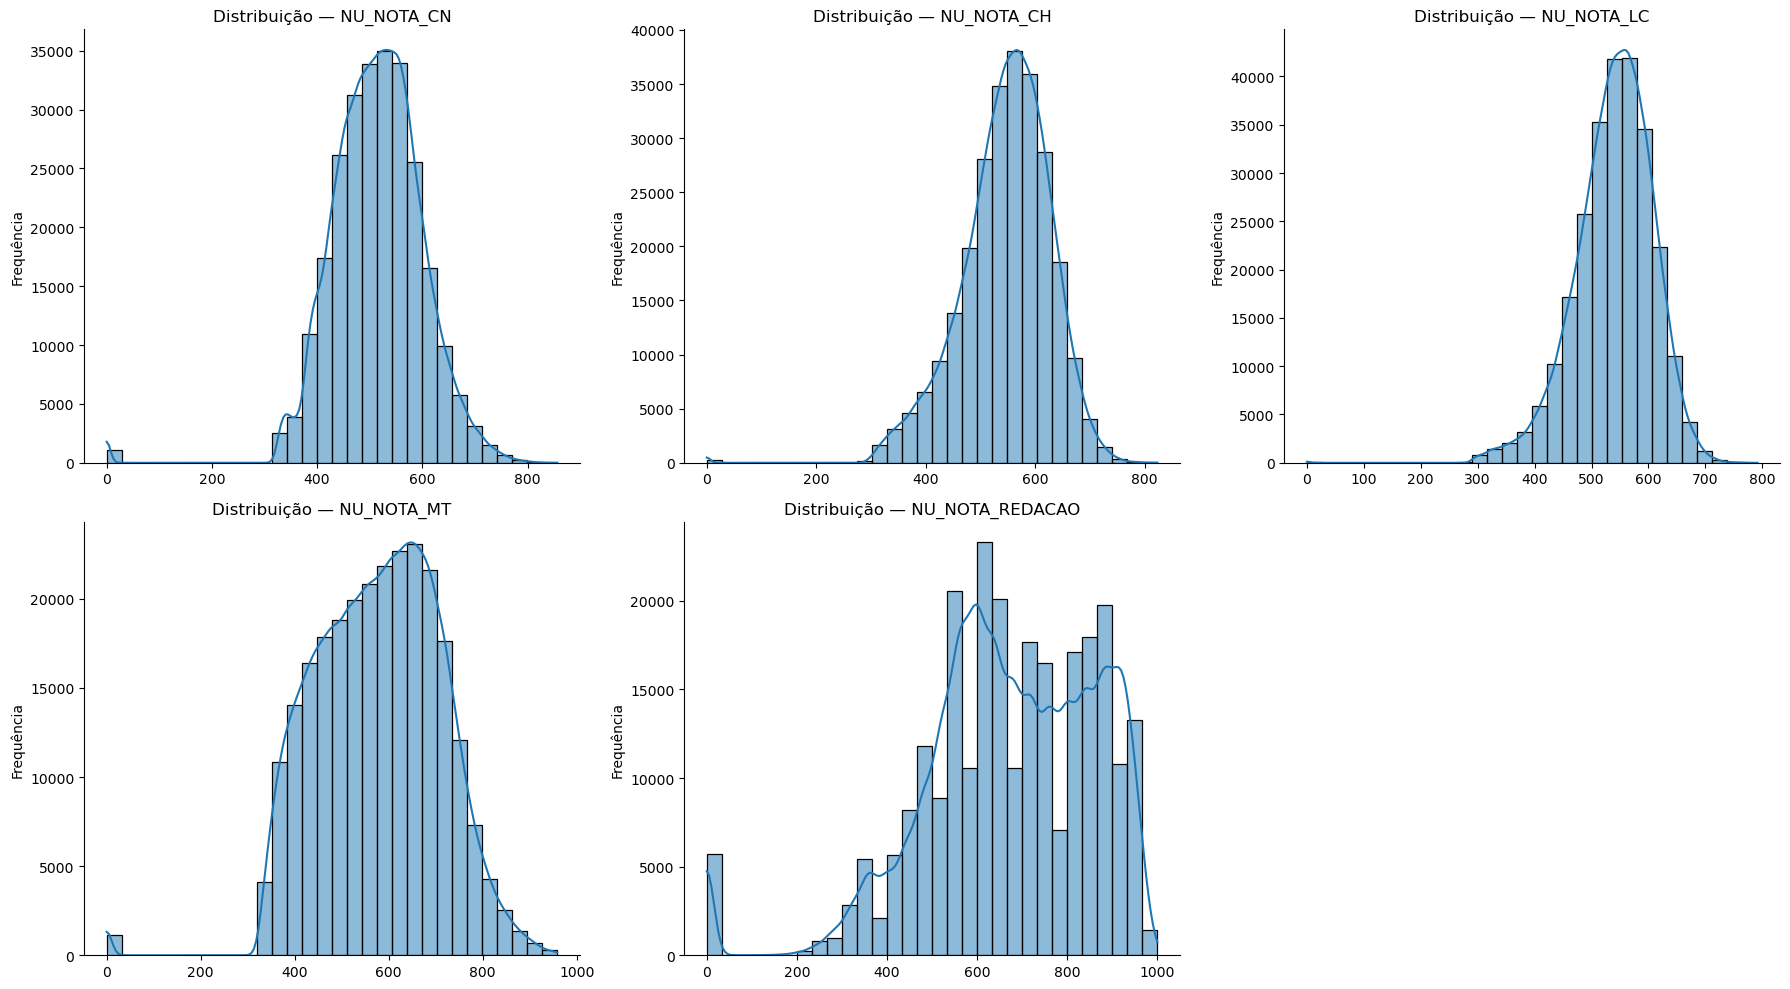

In [7]:
nota_cols = [
    "NU_NOTA_CN", "NU_NOTA_CH", "NU_NOTA_LC",
    "NU_NOTA_MT", "NU_NOTA_REDACAO"
]

num_cols = 3
num_rows = (len(nota_cols) + num_cols - 1) // num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, 10))
axes = axes.flatten()

for i, col in enumerate(nota_cols):
    sns.histplot(df[col], bins=30, kde=True, ax=axes[i])
    axes[i].set_title(f"Distribuição — {col}", fontsize=12)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("Frequência")
    axes[i].spines["top"].set_visible(False)
    axes[i].spines["right"].set_visible(False)

for j in range(len(nota_cols), len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()

A partir dos histogramas podemos observar que todas as notas das àreas da prova seguiram uma distribuição semelhante, exceto pela nota da redação. Ciências da Natureza, Ciências Humanas e Linguagens seguiram uma distribuição relativamente normal, com notas entre 300 e 800. Entretando, o histograma de Matemática revelou que a maioria dos alunos obtém notas entre 300 e 950, revelando uma maior possibilidade de destaque e notas maiores. Por fim, as notas da redação são muito variadas, com muitas redações anuladas. Isso pode ser reforçado e explicado pela natureza dissertativa da redação.

#### 4.2. Variáveis Socioeconômicas <a id="socioeconomica"></a>

##### 4.2.1. Distribuição por Sexo <a id="sex-distribution"></a>

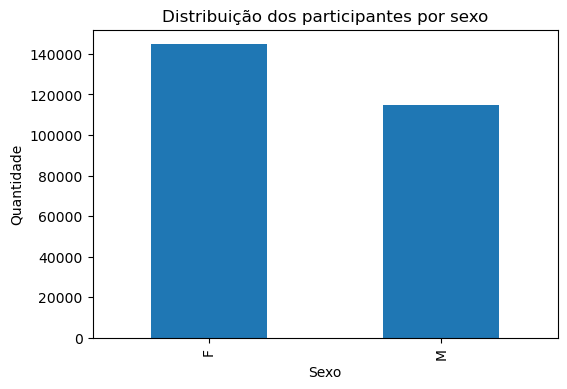

In [8]:
plt.figure(figsize=(6, 4))
df['TP_SEXO'].value_counts().plot(kind='bar')
plt.title("Distribuição dos participantes por sexo")
plt.xlabel("Sexo")
plt.ylabel("Quantidade")
plt.show()

Dessa forma, podemos observar que o Enem de 2023 na região sudeste teve mais inscrições de mulheres do que de homens, cerca de 20.000, refletindo uma tendência crescente de busca por qualificação e autonomia profissional.

##### 4.2.2. Distribuição socioeconômica por nota média <a id="socio_media"></a>

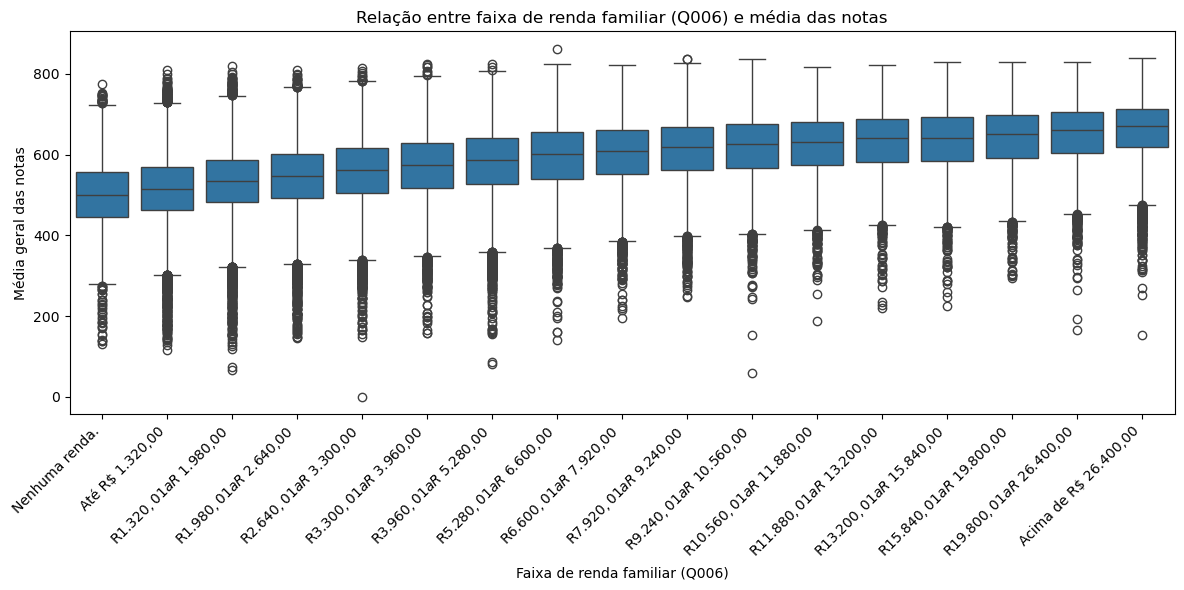

In [9]:
# Q006 = renda familiar (variável ordinal)

mapa_renda = {
    "A": "Nenhuma renda.",
    "B": "Até R$ 1.320,00",
    "C": "R$ 1.320,01 a R$ 1.980,00",
    "D": "R$ 1.980,01 a R$ 2.640,00",
    "E": "R$ 2.640,01 a R$ 3.300,00",
    "F": "R$ 3.300,01 a R$ 3.960,00",
    "G": "R$ 3.960,01 a R$ 5.280,00",
    "H": "R$ 5.280,01 a R$ 6.600,00",
    "I": "R$ 6.600,01 a R$ 7.920,00",
    "J": "R$ 7.920,01 a R$ 9.240,00",
    "K": "R$ 9.240,01 a R$ 10.560,00",
    "L": "R$ 10.560,01 a R$ 11.880,00",
    "M": "R$ 11.880,01 a R$ 13.200,00",
    "N": "R$ 13.200,01 a R$ 15.840,00",
    "O": "R$ 15.840,01 a R$ 19.800,00",
    "P": "R$ 19.800,01 a R$ 26.400,00",
    "Q": "Acima de R$ 26.400,00"
}

df_renda = df[['Q006', 'NU_NOTA_MT', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_CN', 'NU_NOTA_REDACAO']].copy()
df_renda['MEDIA_GERAL'] = df_renda[['NU_NOTA_MT','NU_NOTA_CH','NU_NOTA_LC','NU_NOTA_CN','NU_NOTA_REDACAO']].mean(axis=1)

df_renda['Q006_LABEL'] = df_renda['Q006'].map(mapa_renda)

ordem_labels = [mapa_renda[key] for key in sorted(mapa_renda.keys())]
df_renda['Q006_LABEL'] = pd.Categorical(df_renda['Q006_LABEL'], categories=ordem_labels, ordered=True)

plt.figure(figsize=(12, 6))
sns.boxplot(data=df_renda, x='Q006_LABEL', y='MEDIA_GERAL')
plt.title("Relação entre faixa de renda familiar (Q006) e média das notas")
plt.xlabel("Faixa de renda familiar (Q006)")
plt.ylabel("Média geral das notas")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

O gráfico revela uma correlação direta e positiva entre a renda familiar e o desempenho no exame: à medida que se avança para as faixas salariais mais altas, a mediana das notas sobe consistentemente. Isso demonstra que o contexto socioeconômico atua como um forte preditor de sucesso, sugerindo que o acesso a melhores recursos educacionais e infraestrutura impacta diretamente a nota final do aluno.

Além da tendência de crescimento, a desigualdade fica evidente ao notar que o desempenho médio das classes mais ricas chega a ser superior às melhores notas típicas das classes mais baixas (o terceiro quartil). Embora existam outliers, alunos de baixa renda com pontuações excepcionais, eles são exceções estatísticas. Nas faixas de renda mais alta, atingir notas elevadas deixa de ser um caso isolado e torna-se o padrão esperado.

##### 4.2.3. Relação escola pública/privada e desempenho <a id="tipo_escola"></a>

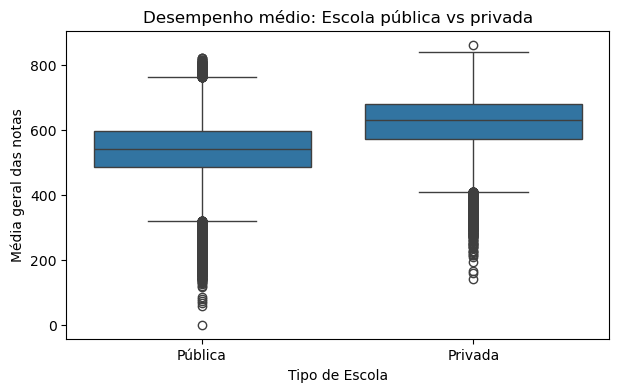

In [10]:
# TP_ESCOLA: 2 = Pública e 3 = Privada

df_esc = df[df['TP_ESCOLA'].isin([2, 3])].copy()

df_esc['MEDIA_GERAL'] = df_esc[['NU_NOTA_MT','NU_NOTA_CH','NU_NOTA_LC','NU_NOTA_CN','NU_NOTA_REDACAO']].mean(axis=1)

mapa_escola = {2: "Pública", 3: "Privada"}
df_esc['TIPO_ESCOLA'] = df_esc['TP_ESCOLA'].map(mapa_escola)

plt.figure(figsize=(7, 4))
sns.boxplot(data=df_esc, x='TIPO_ESCOLA', y='MEDIA_GERAL')
plt.title("Desempenho médio: Escola pública vs privada")
plt.xlabel("Tipo de Escola")
plt.ylabel("Média geral das notas")
plt.show()

Dessa forma, podemos observar que os alunos de escola pública da região sudeste tiveram um desempenho médio cerca de 100 pontos abaixo do desempenho médio de alunos de escola privada, o que reforça a necessidade de cotas para mitigar essa desigualdade.

#### 4.3. Matriz de Correlação <a id="correlacao-matriz"></a>

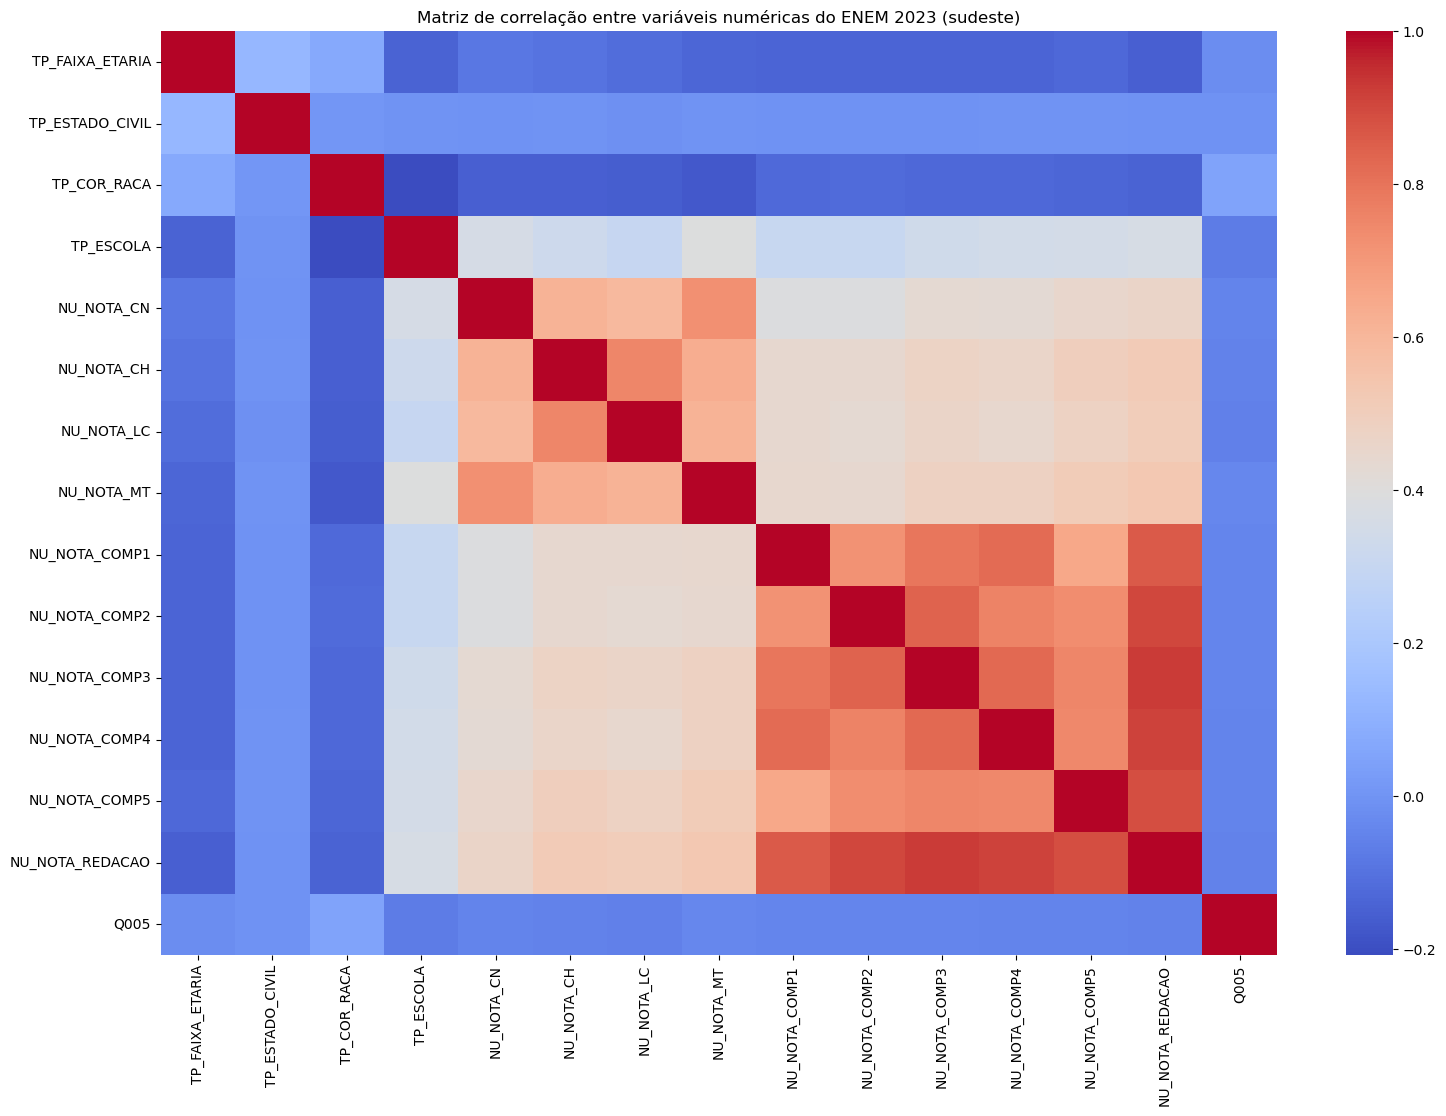

In [11]:
df_num = df.select_dtypes(include=['int64', 'float64']).copy()

# Colunas que não revelam informações relevantes para correlação
cols_to_drop = [
    'TP_NACIONALIDADE', 'TP_LINGUA', 'TP_STATUS_REDACAO',
    'CO_MUNICIPIO_ESC', 'CO_UF_ESC', 'CO_MUNICIPIO_PROVA', 'CO_UF_PROVA',
    'CO_PROVA_CN', 'CO_PROVA_CH', 'CO_PROVA_LC', 'CO_PROVA_MT',
    'TP_PRESENCA_CN', 'TP_PRESENCA_CH', 'TP_PRESENCA_LC', 'TP_PRESENCA_MT',
    'IN_TREINEIRO', 'TP_ENSINO', 'TP_DEPENDENCIA_ADM_ESC', 'TP_LOCALIZACAO_ESC', 'TP_SIT_FUNC_ESC',
    'TP_ST_CONCLUSAO', 'TP_ANO_CONCLUIU'
]

df_num = df_num.drop(columns=[col for col in cols_to_drop if col in df_num.columns])
corr = df_num.corr()

plt.figure(figsize=(18, 12))
sns.heatmap(corr, cmap='coolwarm', annot=False, fmt=".2f")
plt.title("Matriz de correlação entre variáveis numéricas do ENEM 2023 (sudeste)")
plt.show()

A análise da matriz de correlação revela um forte agrupamento positivo entre as notas das diferentes áreas do conhecimento, evidenciado pelo bloco vermelho intenso no canto inferior direito. Isso indica uma alta consistência no desempenho dos estudantes: candidatos que obtêm pontuações elevadas em uma disciplina (como Matemática) tendem a manter esse padrão nas demais (como Ciências da Natureza e Redação). Essa multicolinearidade sugere que o preparo acadêmico do aluno impacta o exame de forma global, sendo raro encontrar casos de disparidade extrema entre o desempenho em exatas e humanas no mesmo indivíduo.

Em contrapartida, destaca-se uma correlação negativa entre a faixa etária (TP_FAIXA_ETARIA) e o desempenho, representada pelas células em tons de azul no cruzamento com as notas. Isso aponta que candidatos mais jovens, geralmente recém-saídos do Ensino Médio e com o conteúdo "fresco" na memória, tendem a alcançar médias superiores em comparação aos participantes mais velhos.

---

### 5. Pré-processamento <a id="data-preprocessing"></a>

Para iniciarmos o pré-processamento pensando em DBSCAN, o primeiro passo é reduzir o dataset somente às variáveis que realmente farão sentido no cálculo da distância.

Sobre as variáveis escolares e de situação: descartamos variáveis como TP_ESCOLA e TP_ENSINO devido à alta presença de dados nulos estruturais (alunos já formados). Além de o DBSCAN não processar valores vazios, essas variáveis são categóricas; seus códigos numéricos distorceriam a métrica de distância e a identificação de vizinhos, essenciais para o algoritmo.

Sobre as competências da Redação: removemos as notas detalhadas (COMP1 a COMP5) para eliminar a redundância, mantendo apenas a nota total. Como o DBSCAN baseia-se em cálculos de distância, a presença de seis variáveis para a mesma prova inflaria artificialmente o peso da Redação, enviesando a formação dos clusters de densidade. E, como vimos, essas features são altamente correlacionadas.

In [12]:
cols_to_drop = [
    # --- Identificadores e Constantes ---
    'CO_MUNICIPIO_ESC', 'CO_UF_ESC', 'SG_UF_ESC', 'NO_MUNICIPIO_ESC',
    'CO_MUNICIPIO_PROVA', 'CO_UF_PROVA', 'SG_UF_PROVA',
    'CO_PROVA_CN', 'CO_PROVA_CH', 'CO_PROVA_LC', 'CO_PROVA_MT',
    'TP_PRESENCA_CN', 'TP_PRESENCA_CH', 'TP_PRESENCA_LC', 'TP_PRESENCA_MT',
    'IN_TREINEIRO', 'TP_STATUS_REDACAO', 'TP_NACIONALIDADE',

    #  Colunas com muitos NaNs ---
    'TP_ENSINO', 'TP_DEPENDENCIA_ADM_ESC', 'TP_LOCALIZACAO_ESC', 'TP_SIT_FUNC_ESC',
    'TP_ANO_CONCLUIU', 'TP_ST_CONCLUSAO',
    
    # --- Redundância sobre notas de redação ---
    'NU_NOTA_COMP1', 'NU_NOTA_COMP2', 'NU_NOTA_COMP3', 'NU_NOTA_COMP4', 'NU_NOTA_COMP5'
]

df_cluster = df.drop(columns=[c for c in cols_to_drop if c in df.columns])
df_cluster.columns

Index(['TP_FAIXA_ETARIA', 'TP_SEXO', 'TP_ESTADO_CIVIL', 'TP_COR_RACA',
       'TP_ESCOLA', 'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT',
       'TP_LINGUA', 'NU_NOTA_REDACAO', 'Q001', 'Q002', 'Q003', 'Q004', 'Q005',
       'Q006', 'Q007', 'Q008', 'Q009', 'Q010', 'Q011', 'Q012', 'Q013', 'Q014',
       'Q015', 'Q016', 'Q017', 'Q018', 'Q019', 'Q020', 'Q021', 'Q022', 'Q023',
       'Q024', 'Q025'],
      dtype='object')

In [13]:
df_cluster.head()

,TP_FAIXA_ETARIA,TP_SEXO,TP_ESTADO_CIVIL,TP_COR_RACA,TP_ESCOLA,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT,TP_LINGUA,...,Q016,Q017,Q018,Q019,Q020,Q021,Q022,Q023,Q024,Q025
0,3,M,1,1,2,523.8,576.3,596.5,628.1,0,...,A,A,A,B,A,A,B,A,A,B
1,3,M,1,2,2,615.2,584.0,594.7,697.1,0,...,B,A,A,D,A,A,D,A,B,B
2,2,F,0,2,2,0.0,554.0,529.6,0.0,0,...,B,A,A,B,A,A,A,A,A,B
3,2,M,1,3,2,680.2,670.1,684.4,706.5,0,...,B,A,B,B,A,A,C,A,B,B
4,2,F,1,0,2,394.5,472.8,474.7,398.1,1,...,A,A,A,B,A,A,A,A,A,A


#### 5.1. Verificação de valores faltantes <a id="missing-values"></a>

In [14]:
missing_df = df_cluster.isnull().sum().to_frame(name="Missing")
missing_df["% Missing"] = (missing_df["Missing"] / len(df_cluster)) * 100
missing_df = missing_df.sort_values("Missing", ascending=False)

missing_df[missing_df["Missing"] > 0]

,Missing,% Missing


Como não há valores faltantes nas features que utilizaremos na clusterização, não há necessidade de tratamento.

#### 5.2. Tratamento de valores ordinais (Q001-Q025) <a id="tratar-questionario"></a>

Abaixo, declaramos o questionário socioeconômico do Enem e suas alternativas como um dicionário Python. Para que essas informações possam ser posteriormente entendidas pelos modelos de clusterização, precisamos codificá-las em valores inteiros.

In [15]:
dicionario_enem_2023 = {
    "Q001": {
        "descricao": "Até que série seu pai, ou o homem responsável por você, estudou?",
        "alternativas": {
            "A": "Nunca estudou.",
            "B": "Não completou a 4ª série/5º ano do Ensino Fundamental.",
            "C": "Completou a 4ª série/5º ano, mas não completou a 8ª série/9º ano do Ensino Fundamental.",
            "D": "Completou a 8ª série/9º ano do Ensino Fundamental, mas não completou o Ensino Médio.",
            "E": "Completou o Ensino Médio, mas não completou a Faculdade.",
            "F": "Completou a Faculdade, mas não completou a Pós-graduação.",
            "G": "Completou a Pós-graduação.",
            "H": "Não sei."
        }
    },
    "Q002": {
        "descricao": "Até que série sua mãe, ou a mulher responsável por você, estudou?",
        "alternativas": {
            "A": "Nunca estudou.",
            "B": "Não completou a 4ª série/5º ano do Ensino Fundamental.",
            "C": "Completou a 4ª série/5º ano, mas não completou a 8ª série/9º ano do Ensino Fundamental.",
            "D": "Completou a 8ª série/9º ano do Ensino Fundamental, mas não completou o Ensino Médio.",
            "E": "Completou o Ensino Médio, mas não completou a Faculdade.",
            "F": "Completou a Faculdade, mas não completou a Pós-graduação.",
            "G": "Completou a Pós-graduação.",
            "H": "Não sei."
        }
    },
    "Q003": {
        "descricao": "Grupo de ocupação do pai/responsável masculino.",
        "alternativas": {
            "A": "Grupo 1: Lavrador, agricultor, pescador, etc.",
            "B": "Grupo 2: Diarista, empregado doméstico, porteiro, cozinheiro, etc.",
            "C": "Grupo 3: Padeiro, pedreiro, mecânico, motorista, etc.",
            "D": "Grupo 4: Professor, técnico, policial, pequeno comerciante, etc.",
            "E": "Grupo 5: Médico, engenheiro, advogado, diretor, oficial militar, etc.",
            "F": "Não sei."
        }
    },
    "Q004": {
        "descricao": "Grupo de ocupação da mãe/responsável feminino.",
        "alternativas": {
            "A": "Grupo 1: Lavradora, agricultora, pescadora, etc.",
            "B": "Grupo 2: Diarista, empregada doméstica, porteira, cozinheira, etc.",
            "C": "Grupo 3: Padeira, pedreira, mecânica, motorista, etc.",
            "D": "Grupo 4: Professora, técnica, policial, pequena comerciante, etc.",
            "E": "Grupo 5: Médica, engenheira, advogada, diretora, oficial militar, etc.",
            "F": "Não sei."
        }
    },
    "Q005": {
        "descricao": "Incluindo você, quantas pessoas moram atualmente em sua residência?",
        "alternativas": {i: str(i) for i in range(1, 21)} # Cria chaves inteiras de 1 a 20
    },
    "Q006": {
        "descricao": "Qual é a renda mensal de sua família? (Valores estimados 2023)",
        "alternativas": {
            "A": "Nenhuma renda.",
            "B": "Até R$ 1.320,00.",
            "C": "De R$ 1.320,01 até R$ 1.980,00.",
            "D": "De R$ 1.980,01 até R$ 2.640,00.",
            "E": "De R$ 2.640,01 até R$ 3.300,00.",
            "F": "De R$ 3.300,01 até R$ 3.960,00.",
            "G": "De R$ 3.960,01 até R$ 5.280,00.",
            "H": "De R$ 5.280,01 até R$ 6.600,00.",
            "I": "De R$ 6.600,01 até R$ 7.920,00.",
            "J": "De R$ 7.920,01 até R$ 9.240,00.",
            "K": "De R$ 9.240,01 até R$ 10.560,00.",
            "L": "De R$ 10.560,01 até R$ 11.880,00.",
            "M": "De R$ 11.880,01 até R$ 13.200,00.",
            "N": "De R$ 13.200,01 até R$ 15.840,00.",
            "O": "De R$ 15.840,01 até R$ 19.800,00.",
            "P": "De R$ 19.800,01 até R$ 26.400,00.",
            "Q": "Acima de R$ 26.400,00."
        }
    },
    "Q007": {
        "descricao": "Na sua residência trabalha empregado(a) doméstico(a)?",
        "alternativas": {
            "A": "Não.",
            "B": "Sim, 1 ou 2 dias por semana.",
            "C": "Sim, 3 ou 4 dias por semana.",
            "D": "Sim, pelo menos 5 dias por semana."
        }
    },
    "Q008": {
        "descricao": "Na sua residência tem banheiro?",
        "alternativas": {"A": "Não", "B": "Sim, um", "C": "Sim, dois", "D": "Sim, três", "E": "Sim, quatro ou mais"}
    },
    "Q009": {
        "descricao": "Na sua residência tem quartos para dormir?",
        "alternativas": {"A": "Não", "B": "Sim, um", "C": "Sim, dois", "D": "Sim, três", "E": "Sim, quatro ou mais"}
    },
    "Q010": {
        "descricao": "Na sua residência tem carro?",
        "alternativas": {"A": "Não", "B": "Sim, um", "C": "Sim, dois", "D": "Sim, três", "E": "Sim, quatro ou mais"}
    },
    "Q011": {
        "descricao": "Na sua residência tem motocicleta?",
        "alternativas": {"A": "Não", "B": "Sim, uma", "C": "Sim, duas", "D": "Sim, três", "E": "Sim, quatro ou mais"}
    },
    "Q012": {
        "descricao": "Na sua residência tem geladeira?",
        "alternativas": {"A": "Não", "B": "Sim, uma", "C": "Sim, duas", "D": "Sim, três", "E": "Sim, quatro ou mais"}
    },
    "Q013": {
        "descricao": "Na sua residência tem freezer?",
        "alternativas": {"A": "Não", "B": "Sim, um", "C": "Sim, dois", "D": "Sim, três", "E": "Sim, quatro ou mais"}
    },
    "Q014": {
        "descricao": "Na sua residência tem máquina de lavar roupa?",
        "alternativas": {"A": "Não", "B": "Sim, uma", "C": "Sim, duas", "D": "Sim, três", "E": "Sim, quatro ou mais"}
    },
    "Q015": {
        "descricao": "Na sua residência tem máquina de secar roupa?",
        "alternativas": {"A": "Não", "B": "Sim, uma", "C": "Sim, duas", "D": "Sim, três", "E": "Sim, quatro ou mais"}
    },
    "Q016": {
        "descricao": "Na sua residência tem forno micro-ondas?",
        "alternativas": {"A": "Não", "B": "Sim, um", "C": "Sim, dois", "D": "Sim, três", "E": "Sim, quatro ou mais"}
    },
    "Q017": {
        "descricao": "Na sua residência tem máquina de lavar louça?",
        "alternativas": {"A": "Não", "B": "Sim, uma", "C": "Sim, duas", "D": "Sim, três", "E": "Sim, quatro ou mais"}
    },
    "Q018": {
        "descricao": "Na sua residência tem aspirador de pó?",
        "alternativas": {"A": "Não", "B": "Sim"}
    },
    "Q019": {
        "descricao": "Na sua residência tem televisão em cores?",
        "alternativas": {"A": "Não", "B": "Sim, uma", "C": "Sim, duas", "D": "Sim, três", "E": "Sim, quatro ou mais"}
    },
    "Q020": {
        "descricao": "Na sua residência tem aparelho de DVD?",
        "alternativas": {"A": "Não", "B": "Sim"}
    },
    "Q021": {
        "descricao": "Na sua residência tem TV por assinatura?",
        "alternativas": {"A": "Não", "B": "Sim"}
    },
    "Q022": {
        "descricao": "Na sua residência tem telefone celular?",
        "alternativas": {"A": "Não", "B": "Sim, um", "C": "Sim, dois", "D": "Sim, três", "E": "Sim, quatro ou mais"}
    },
    "Q023": {
        "descricao": "Na sua residência tem telefone fixo?",
        "alternativas": {"A": "Não", "B": "Sim"}
    },
    "Q024": {
        "descricao": "Na sua residência tem computador?",
        "alternativas": {"A": "Não", "B": "Sim, um", "C": "Sim, dois", "D": "Sim, três", "E": "Sim, quatro ou mais"}
    },
    "Q025": {
        "descricao": "Na sua residência tem acesso à Internet?",
        "alternativas": {"A": "Não", "B": "Sim"}
    }
}

Agora, cada possibilidade de resposta será convertida em um número específico (A=0, B=1, C=2 ... Q=16):

In [16]:
colunas_para_transformar = [
    'Q001', 'Q002', 'Q003', 'Q004', # Q005 já é numérico
    'Q006', 'Q007', 'Q008', 'Q009', 'Q010', 'Q011', 'Q012', 'Q013', 'Q014',
    'Q015', 'Q016', 'Q017', 'Q018', 'Q019', 'Q020', 'Q021', 'Q022', 'Q023',
    'Q024', 'Q025'
]

# Dicionário de mapeamento global (A=0, B=1, C=2 ... Q=16)
letras = string.ascii_uppercase[:17]
mapeamento = {letra: i for i, letra in enumerate(letras)}

df_cluster[colunas_para_transformar] = df_cluster[colunas_para_transformar].replace(mapeamento)

/var/folders/_b/hxlm5zgn0wl55w3f5d1t5j7h0000gn/T/ipykernel_58381/919093593.py:12: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_cluster[colunas_para_transformar] = df_cluster[colunas_para_transformar].replace(mapeamento)


#### 5.3. Encoding de variáveis categóricas <a id="encoding"></a>

Mapeando variáveis binárias:

In [17]:
df_cluster['TP_SEXO'] = df_cluster['TP_SEXO'].map({'F': 0, 'M': 1})
df_cluster["TP_ESCOLA"] = df_cluster["TP_ESCOLA"].map({2: 0, 3: 1})

One-hot encoding direto para variáveis nominais:

In [18]:
colunas_nominais = ['TP_COR_RACA', 'TP_ESTADO_CIVIL']
df_cluster = pd.get_dummies(df_cluster, columns=colunas_nominais, drop_first=True)

#### 5.4. Normalizando a escala <a id="standard-scaler"></a>

Para que os modelo consigam interpretar os dados, precisamos normalizá-los com *StandarScaler*:

In [19]:
scaler = StandardScaler()
df_preprocessed = pd.DataFrame(
    scaler.fit_transform(df_cluster),
    columns=df_cluster.columns
)

In [20]:
df_preprocessed.head()

,TP_FAIXA_ETARIA,TP_SEXO,TP_ESCOLA,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT,TP_LINGUA,NU_NOTA_REDACAO,Q001,...,Q025,TP_COR_RACA_1,TP_COR_RACA_2,TP_COR_RACA_3,TP_COR_RACA_4,TP_COR_RACA_5,TP_ESTADO_CIVIL_1,TP_ESTADO_CIVIL_2,TP_ESTADO_CIVIL_3,TP_ESTADO_CIVIL_4
0,0.281241,1.123444,-0.755336,0.101328,0.369574,0.837846,0.380025,-0.555619,-0.354152,-1.305476,...,0.160278,0.813573,-0.326320,-0.617477,-0.124846,-0.049033,0.205727,-0.069819,-0.086433,-0.012575
1,0.281241,1.123444,-0.755336,1.163715,0.464673,0.811236,0.908538,-0.555619,0.057806,1.796033,...,0.160278,-1.229146,3.064473,-0.617477,-0.124846,-0.049033,0.205727,-0.069819,-0.086433,-0.012575
2,-0.724866,-0.890120,-0.755336,-5.987051,0.094158,-0.151164,-4.430978,-0.555619,-1.281056,-1.925777,...,0.160278,-1.229146,3.064473,-0.617477,-0.124846,-0.049033,-4.860817,-0.069819,-0.086433,-0.012575
3,-0.724866,1.123444,-0.755336,1.919241,1.528050,2.137309,0.980538,-0.555619,1.602647,-0.064872,...,0.160278,-1.229146,-0.326320,1.619494,-0.124846,-0.049033,0.205727,-0.069819,-0.086433,-0.012575
4,-0.724866,-0.890120,-0.755336,-1.401588,-0.908701,-0.962773,-1.381686,1.799793,-1.487035,-1.305476,...,-6.239177,-1.229146,-0.326320,-0.617477,-0.124846,-0.049033,0.205727,-0.069819,-0.086433,-0.012575


Agora, o dataframe está padronizado e normalizado, pronto para ser clusterizado.

---

### 6. Modelagem <a id="modeling"></a>

#### 6.1. Redução de dimensionalidade (PCA) <a id="pca"></a>

Como o dataset possui um grande número de variáveis, realizar a clusterização diretamente em seu espaço original demandaria um alto custo computacional e poderia introduzir ruído devido à presença de atributos altamente correlacionados. Para mitigar esse problema, aplicamos o método de Análise de Componentes Principais (PCA) com o objetivo de reduzir a dimensionalidade do conjunto de dados preservando ao máximo a variabilidade original.

Definimos n_components = 0.70, de forma que o PCA seleciona automaticamente o menor número de componentes capazes de reter 70% da variância total do dataset. Após o ajuste, os dados transformados passaram de centenas de variáveis iniciais para apenas 19 componentes principais, conforme demonstrado abaixo. Esse foi o melhor resultado obtido por nós.

In [21]:
pca = PCA(n_components=0.70)
X_pca = pca.fit_transform(df_preprocessed)
X_pca.shape

(259328, 19)

#### 6.2. Clusterização 1: DBSCAN <a id="dbscan"></a>

##### 6.2.1. Método do cotovelo (*eps*) <a id="elbow-method-eps"></a>

Para estimar um valor adequado para o parâmetro eps do DBSCAN, que controla o raio de vizinhança necessário para que um ponto seja considerado parte de um cluster, utilizamos o método do gráfico k-distance. Como seria inviável calcular as distâncias entre todos os pontos do dataset completo por questões de custo computacional, realizamos uma amostragem aleatória de 80 mil observações dos dados já reduzidos via PCA.

Em seguida, definimos k = log(n) para determinar o número de vizinhos mais adequado de acordo com o tamanho da amostra e calculamos a distância até o k-ésimo vizinho mais próximo de cada ponto. As distâncias foram ordenadas e plotadas, permitindo observar a região de inflexão da curva, que corresponde ao valor sugerido de eps, garantindo um balanceamento entre sensibilidade a ruídos e formação de clusters significativos.

In [22]:
sample_size = 80_000
idx = np.random.choice(len(X_pca), sample_size, replace=False)
X_sample = X_pca[idx]

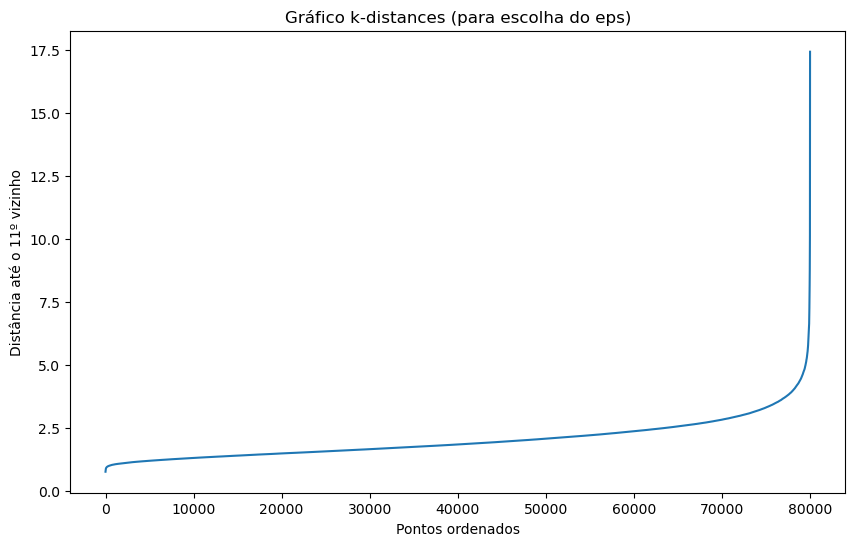

In [23]:
k = int(np.log(len(X_sample)))

neighbors = NearestNeighbors(n_neighbors=k)
neighbors_fit = neighbors.fit(X_sample)
distances, indices = neighbors_fit.kneighbors(X_sample)

distances = np.sort(distances[:, k-1])
plt.figure(figsize=(10,6))
plt.plot(distances)
plt.title("Gráfico k-distances (para escolha do eps)")
plt.xlabel("Pontos ordenados")
plt.ylabel(f"Distância até o {k}º vizinho")
plt.show()

A análise do gráfico k-distance evidenciou uma inflexão onde as distâncias passam a crescer de forma acentuada. Esse ponto ocorre aproximadamente em 2, indicando que esse é o valor adequado para o parâmetro *eps* do DBSCAN.

##### 6.2.2. Treinamento <a id="training-dbscan"></a>

In [24]:
print("➡️  Iniciando DBSCAN...")
print(f"Dimensão dos dados de entrada: {X_pca.shape}")

dbscan = DBSCAN(
    eps=2.0,
    min_samples=100, # log(n) ≈ 11, mas valores maiores geraram clusters mais estáveis e menos ruído
    metric='euclidean',
    algorithm='kd_tree',
    n_jobs=-1
)

labels = dbscan.fit_predict(X_pca)

n_clusters = len(set(labels) - {-1})
n_noise = np.sum(labels == -1)

print("\n📝 Resultados do DBSCAN:")
print(f"Número de clusters encontrados: {n_clusters}")
print(f"Pontos classificados como ruído (label = -1): {n_noise}")

df_dbscan = df_cluster.copy()
df_dbscan['cluster'] = labels

➡️  Iniciando DBSCAN...
Dimensão dos dados de entrada: (259328, 19)

📝 Resultados do DBSCAN:
Número de clusters encontrados: 6
Pontos classificados como ruído (label = -1): 87508


À primeira vista, nota-se que o número de registros classificados como ruído é bem alto, 33.74% do dataset original.

##### 6.2.3. Avaliação dos clusters <a id="evaluation-dbscan"></a>

In [25]:
df_analise = df_dbscan[df_dbscan['cluster'] != -1].copy()
print(df_analise['cluster'].unique())
print(df_analise['cluster'].value_counts().sort_index())

[0 1 2 4 3 5]
cluster
0    159994
1      8086
2      2983
3       318
4       230
5       209
Name: count, dtype: int64


À primeira vista, a distribuição desbalanceada dos clusters, com o Cluster 0 concentrando cerca de 93% da amostra (159.994 alunos), indica que a grande maioria dos estudantes possui um perfil de comportamento (notas e dados socioeconômicos) muito semelhante e contínuo, formando uma grande "massa principal" densa.

Isso sugere que, para o DBSCAN, não existem fronteiras rígidas separando os grupos sociais ou de desempenho (como "ilhas" isoladas), mas sim um degradê suave onde a maioria se mistura. 

Os clusters menores (1 a 5), que somam menos de 7% dos dados, provavelmente representam nichos de exceção ou anomalias estatísticas, pequenos grupos que, por combinações muito específicas de renda extrema ou notas muito discrepantes, conseguiram se diferenciar matematicamente do "aluno médio".

In [26]:
# Vamos analisar o Cluster 0, Cluster 1 e o Ruído (-1)
# O Ruído é importante para ver se ele é o "meio termo"
df_analise = df_dbscan[df_dbscan['cluster'].isin([0, 1, -1])].copy()

mapa_nomes = {0: '0: A Massa (160k)', 1: '1: O Grupo Distinto (8k)', -1: '-1: Ruído/Transição (87k)'}
df_analise['Nome_Cluster'] = df_analise['cluster'].map(mapa_nomes)

colunas_verificacao = ['Q006', 'Q024', 'Q001', 'Q002', 'NU_NOTA_REDACAO', 'NU_NOTA_MT', 'NU_NOTA_CN'] 

df_analise.groupby('Nome_Cluster')[colunas_verificacao].mean().round(2)

,Q006,Q024,Q001,Q002,NU_NOTA_REDACAO,NU_NOTA_MT,NU_NOTA_CN
Nome_Cluster,,,,,,,
-1: Ruído/Transição (87k),6.17,1.28,4.21,4.28,640.89,567.51,507.59
0: A Massa (160k),5.33,1.07,4.09,4.27,687.27,588.66,521.41
1: O Grupo Distinto (8k),3.31,0.62,3.71,3.84,638.08,537.85,493.46


/var/folders/_b/hxlm5zgn0wl55w3f5d1t5j7h0000gn/T/ipykernel_58381/2683001502.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Nome_Cluster', y='Q006', data=df_analise, palette='coolwarm')


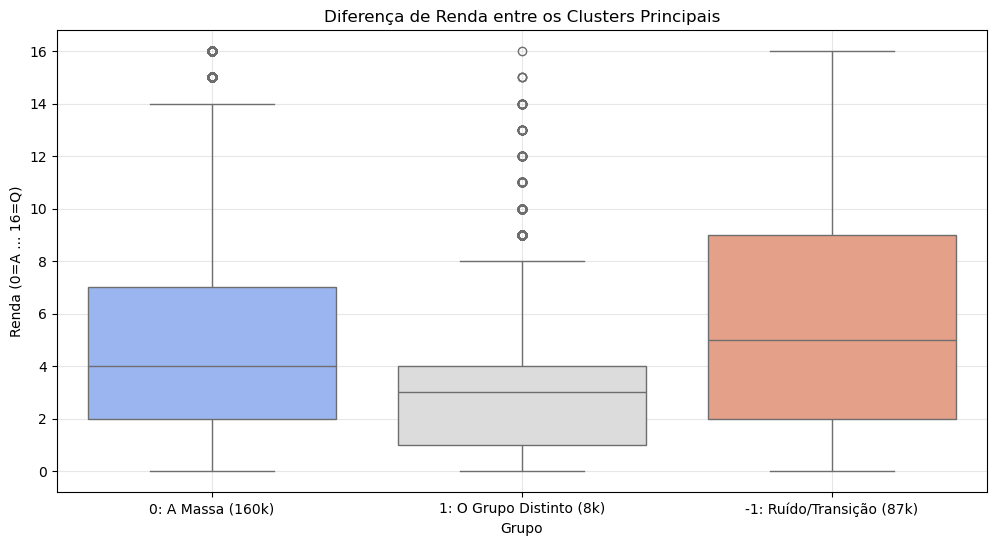

In [27]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='Nome_Cluster', y='Q006', data=df_analise, palette='coolwarm')
plt.title('Diferença de Renda entre os Clusters Principais')
plt.xlabel('Grupo')
plt.ylabel('Renda (0=A ... 16=Q)')
plt.grid(True, alpha=0.3)
plt.show()

A análise dos clusters gerados pelo DBSCAN mostra uma separação limitada e pouco informativa dos perfis dos participantes:

- O Cluster 0 (“A Massa”) concentra a maior parte dos estudantes, com valores intermediários nas questões socioeconômicas e desempenho acadêmico, representando o grupo majoritário padrão.

- O Cluster 1 (“O Grupo Distinto”), apesar de pequeno, reúne participantes com maior poder aquisitivo (Q006 e Q024 mais baixos, indicando renda familiar maior e maior escolaridade dos pais) e desempenho relativamente inferior nas notas, configurando um perfil atípico. 

- O grupo -1 (“Ruído/Transição”) apresenta valores médios entre os dois clusters e inclui estudantes que não se encaixaram bem em nenhum dos perfis anteriores. 

No geral, os resultados indicam que o DBSCAN não conseguiu capturar padrões claros ou bem segmentados, reforçando seu desempenho limitado para esse conjunto de dados. Assim, sugerimos outra abordagem de clusterização: o K-Means.

#### 6.3. Clusterização 2: K-Means <a id="kmeans"></a>

##### 6.3.1. Método do cotovelo (*K*) <a id="elbow-method-k"></a>

Para determinar o número ideal de clusters, utilizamos o Método do Cotovelo, que avalia a variação da soma das distâncias internas (inércia) à medida que o valor de k aumenta.

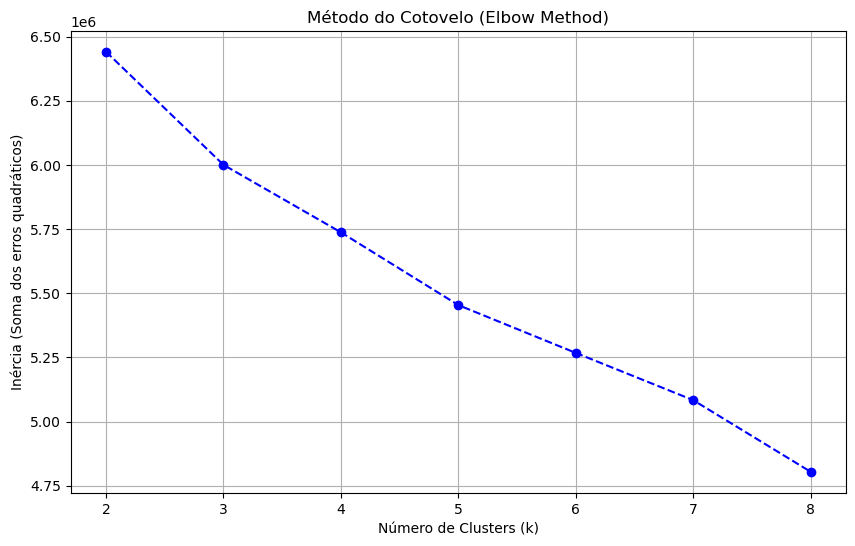

In [28]:
inertia = []
range_k = range(2, 9)

for k in range_k:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_pca)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range_k, inertia, marker='o', linestyle='--', color='b')
plt.title('Método do Cotovelo (Elbow Method)')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Inércia (Soma dos erros quadráticos)')
plt.xticks(range_k)
plt.grid(True)
plt.show()

Quando a linha desce suavemente assim (sem uma quina afiada muito clara), significa que os dados são um gradiente contínuo. Não existem grupos naturalmente separados (como "ilhas"), mas sim uma transição suave de notas e renda (como uma rampa). Isso confirma o que o DBSCAN mostrou (aquela "massa" única).

Assim, observando a curva e pensando nos clusters, optamos por K = 3.

##### 6.3.2. Treinamento <a id="training-kmeans"></a>

In [29]:
k = 3

kmeans = KMeans(
    n_clusters=k,
    init='k-means++',
    n_init=10,
    random_state=42
)

labels_kmeans = kmeans.fit_predict(X_pca)

df_cluster_km = df_cluster.copy()
df_cluster_km['cluster_kmeans'] = labels_kmeans

In [30]:
df_cluster_km.to_parquet("df_cluster_km.parquet", engine="pyarrow")

##### 6.3.2. Avaliação dos clusters <a id="evaluation-kmeans"></a>

In [31]:
df_analise = df_cluster_km[df_cluster_km['cluster_kmeans'] != -1].copy()
print(df_analise['cluster_kmeans'].unique())
print(df_analise['cluster_kmeans'].value_counts().sort_index())

[2 1 0]
cluster_kmeans
0     47202
1    113695
2     98431
Name: count, dtype: int64


À primeira vista, observamos uma distribuição equilibrada de estudantes entre os três clusters formados pelo K-Means, sem concentrações extremas que indiquem colapsos ou agrupamentos artificiais. O Cluster 1 é o maior grupo, seguido pelos Clusters 2 e 0, mas todos mantêm proporções suficientemente próximas para permitir comparações significativas. Essa divisão sugere que o modelo conseguiu segmentar o conjunto de dados de maneira estruturada, identificando padrões relevantes em diferentes perfis de estudantes.

In [32]:
colunas_analise = ['Q006', 'Q024', 'Q001', 'NU_NOTA_REDACAO', 'NU_NOTA_MT']
resumo_kmeans = df_cluster_km.groupby('cluster_kmeans')[colunas_analise].mean().sort_values(by='Q006')

resumo_kmeans.round(2)

,Q006,Q024,Q001,NU_NOTA_REDACAO,NU_NOTA_MT
cluster_kmeans,,,,,
2,2.53,0.43,3.43,564.68,490.92
1,5.60,1.17,4.27,709.32,609.90
0,11.51,2.42,5.11,788.18,685.42


A análise das médias dos indicadores socioeconômicos e de desempenho revela uma estratificação clara entre os três clusters formados pelo K-Means.

- O Cluster 2 corresponde ao grupo de menor renda e menor escolaridade familiar, apresentando também as menores notas de redação e matemática.

- O Cluster 1 representa um perfil intermediário, com renda e escolaridade moderadas e desempenho acadêmico superior ao do primeiro grupo.

- O Cluster 0 concentra os estudantes com maior renda e maior nível educacional dos pais, refletindo também as maiores notas entre os clusters.

Esses resultados indicam que o K-Means capturou um gradiente socioeconômico que se reflete diretamente no desempenho no ENEM.

/var/folders/_b/hxlm5zgn0wl55w3f5d1t5j7h0000gn/T/ipykernel_58381/9523592.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


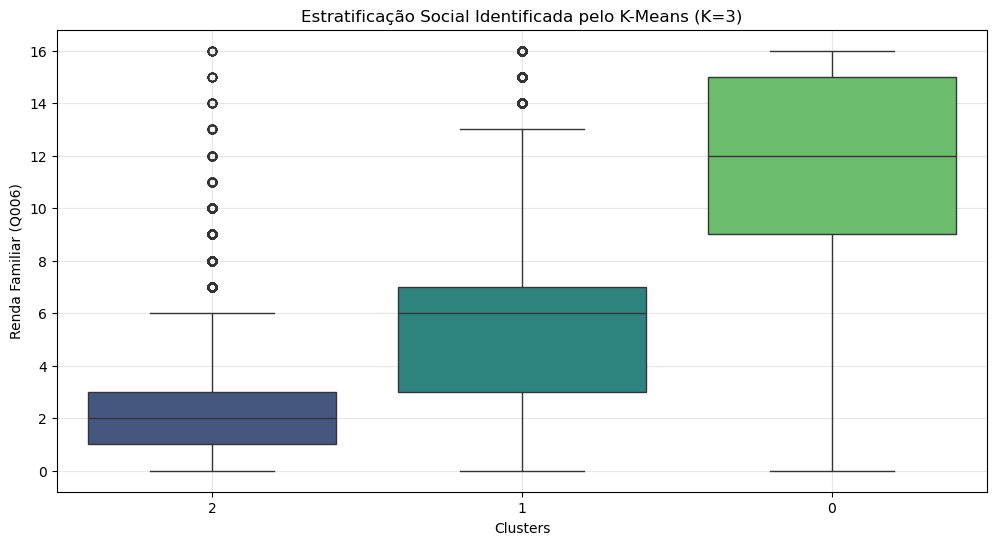

In [33]:
plt.figure(figsize=(12, 6))
sns.boxplot(
    x='cluster_kmeans',
    y='Q006',
    data=df_cluster_km,
    order=resumo_kmeans.index,
    palette='viridis'
)
plt.title(f'Estratificação Social Identificada pelo K-Means (K={k})')
plt.xlabel('Clusters')
plt.ylabel('Renda Familiar (Q006)')
plt.grid(alpha=0.3)
plt.show()

In [34]:
resumo_escola = (df_analise['TP_ESCOLA'] == 1).groupby(df_analise['cluster_kmeans']).mean() * 100
print("Porcentagem de Alunos de Escola Privada por Cluster")
print(resumo_escola.sort_values().round(2))

Porcentagem de Alunos de Escola Privada por Cluster
cluster_kmeans
2     5.78
1    41.03
0    88.69
Name: TP_ESCOLA, dtype: float64


Os resultados mostram que o K-Means com K = 3 foi capaz de separar muito bem os grupos de estudantes com base no tipo de escola. O cluster 2 apresenta forte predominância de alunos de escolas públicas (apenas 5,78% de privadas), enquanto o cluster 1 representa um grupo misto (41,03% de privadas) e o cluster 0 concentra majoritariamente alunos de escolas privadas (88,69%).

Essa separação nítida indica que o algoritmo captou uma estrutura real nos dados, formando clusters coerentes e expressivos, o que valida a escolha de K = 3 como um número adequado para segmentação neste contexto.

---

### 7. Aplicação: RAG <a id="rag"></a>

A ideia por trás deste RAG é oferecer inteligência estratégica sobre o cenário educacional, segmentando estudantes em perfis demográficos distintos. Ao cruzar dados de vulnerabilidade social com resultados de avaliações, o sistema fornece diagnósticos precisos sobre quais grupos necessitam de intervenção prioritária, facilitando a tomada de decisão para políticas públicas baseadas em evidências.

Para isso, criamos três arquivos de texto para alimentar o RAG, sendo eles:

- *base_conhecimento_enem.txt*
- *programas_sociais.txt*
- *resumo_estatistico.txt*

A base de conhecimento foi gerada de forma a conter 10 registros aleatórios de cada cluster, informando semanticamente ao RAG o perfil do estudante e as respostas relevantes fornecidas por ele no questionário socioeconômico, como renda e acesso a internet e computadores.

Já o arquivo de programas sociais contém diversos textos sobre políticas públicas e como elas podem afetar os estudantes de diversos contextos. A exemplo disso, temos cursinhos pré-vestibulares gratuitos e o Auxílio Conectividade, que fornece um chip com acesso a internet móvel aos alunos.

Por fim, o resumo estatístico fornece de forma semântica ao RAG uma descrição das principais características de cada cluster.

#### 7.1. Instalação de dependências <a id="dependencias"></a>

Executamos o Ollama localmente. Para isso, é necessário seguir os seguintes passos:

1. Prepare o Motor (via Terminal):
    - Instale o Ollama (https://ollama.com)
    - Escreva no terminal: *ollama pull llama3* (isso baixa o cérebro da IA para sua máquina).
    - Logo após a instalação, inicie o servidor escrevendo no terminal: *ollama serve*

2. No ambiente de execução deste notebook, instale as libs:

In [ ]:
!pip install langchain langchain-core langchain-community langchain-text-splitters langchain-ollama langchain-experimental faiss-cpu

#### 7.2. Iniciando o RAG com Ollama <a id="ollama"></a>

In [36]:
from langchain_community.document_loaders import DirectoryLoader, TextLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import FAISS

from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_ollama import OllamaEmbeddings, ChatOllama

DATA_PATH = "./input_rag"

def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

def construir_rag_ollama():
    print("🦙 Iniciando RAG com OLLAMA (Local)...")

    if not os.path.exists(DATA_PATH):
        raise FileNotFoundError(f"A pasta {DATA_PATH} não existe!")

    loader = DirectoryLoader(DATA_PATH, glob="*.txt", loader_cls=TextLoader, loader_kwargs={'encoding': 'utf-8'})
    docs = loader.load()
    print(f"   -> {len(docs)} documentos carregados.")

    text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
    splits = text_splitter.split_documents(docs)

    print("   -> Criando embeddings locais (Llama3)...")
    embeddings = OllamaEmbeddings(model="llama3")

    vectorstore = FAISS.from_documents(documents=splits, embedding=embeddings)
    retriever = vectorstore.as_retriever(
        search_type="mmr",                      # diversification — evita trazer 5 trechos iguais
        search_kwargs={"k": 8, "fetch_k": 20}   # busca mais e reordena os melhores
    )

    llm = ChatOllama(model="llama3", temperature=0.1)

    system_prompt = (
        "Você é um Assistente Especialista em ENEM e Políticas Públicas Educacionais."
        "Use APENAS o contexto fornecido abaixo para responder."
        "Se não souber, diga que não sabe."
        "\n\n--- CONTEXTO ---\n{context}"
    )

    prompt = ChatPromptTemplate.from_messages([
        ("system", system_prompt),
        ("human", "{input}"),
    ])

    question_answer_chain = prompt | llm

    rag_chain = (
        {"context": retriever | format_docs, "input": RunnablePassthrough()}
        | question_answer_chain
    )

    print("✅ RAG Local pronto!")
    return rag_chain

rag_system = construir_rag_ollama()

def perguntar(pergunta):
    print(f"\n❓: {pergunta}")
    response = rag_system.invoke(pergunta)
    print(f"🦙: {response}")

🦙 Iniciando RAG com OLLAMA (Local)...
   -> 3 documentos carregados.
   -> Criando embeddings locais (Llama3)...
✅ RAG Local pronto!


#### 7.3. Perguntando ao RAG <a id="perguntas"></a>

In [37]:
perguntar("Qual a nota média da redação de estudantes do cluster 2?.")


❓: Qual a nota média da redação de estudantes do cluster 2?.
🦙: content='De acordo com o contexto fornecido, a nota média da Redação dos estudantes do Cluster 2 é de 564.7.' additional_kwargs={} response_metadata={'model': 'llama3', 'created_at': '2025-12-01T14:54:36.100917Z', 'done': True, 'done_reason': 'stop', 'total_duration': 28309224375, 'load_duration': 148216750, 'prompt_eval_count': 1506, 'prompt_eval_duration': 16202742042, 'eval_count': 31, 'eval_duration': 10892740540, 'logprobs': None, 'model_name': 'llama3', 'model_provider': 'ollama'} id='lc_run--bd6ecc8f-da7f-4430-910f-5a121750828d-0' usage_metadata={'input_tokens': 1506, 'output_tokens': 31, 'total_tokens': 1537}


Dentre outras perguntas que fizemos a ele, e que destacam seu papel como um agente para análise dos estudantes dos clusters e indicador de soluções via políticas públicas, encontram-se:

❓: Quais políticas públicas podem ajudar os alunos do cluster 0?.

🦙: content='Como o Cluster 0 é composto por estudantes de alta renda e ensino privado, não há necessidade de políticas públicas específicas para auxílio de desempenho. A síntese do perfil indica que estes estudantes possuem condições privilegiadas e, portanto, não demandam políticas públicas específicas para auxílio de desempenho.'



❓: Quais políticas públicas podem ajudar os alunos do cluster 1?.

🦙: content='Com base no perfil do Cluster 1, que é caracterizado por estudantes de classe média baixa com renda familiar na Faixa G (entre R$ 3.9 mil e R$ 5.2 mil mensais), oriundos predominantemente de escolas públicas, as políticas públicas que podem ajudar esses alunos são:\n\n1. Auxílio Conectividade: O programa que oferece chip com internet móvel gratuita ou pacote de dados subsidiado pode ser benéfico para os estudantes do Cluster 1, pois muitos deles podem não ter acesso a internet em casa e isso pode afetar negativamente seu desempenho escolar.\n2. Vale-Livros / Editais de Material Didático: O programa que fornece crédito para compra de livros didáticos, técnicos ou universitários pode ser útil para os estudantes do Cluster 1, pois muitos deles podem não ter condições financeiras para comprar materiais escolares.\n3. Pé-de-Meia: O programa que oferece pagamento mensal para incentiviar a permanência escolar pode ser benéfico para os estudantes do Cluster 1, pois eles podem precisar de apoio financeiro para continuar seus estudos.\n\nAlém disso, é importante lembrar que o Cluster 1 apresenta um desempenho acadêmico médio/regular e que muitos dos estudantes nesse grupo provêm de escolas públicas. Portanto, políticas públicas que visem melhorar a qualidade da educação básica e superior, como a Lei de Cotas (2024), podem também ser benéficas para esses alunos.'



❓: Quais políticas públicas podem ajudar os alunos do cluster 2?.

🦙: content='Com base no perfil do Cluster 2, que apresenta alta vulnerabilidade socioeconômica e desempenho escolar mais baixo entre todos os clusters analisados, as seguintes políticas públicas podem ajudar esses estudantes:\n\n1. Pé-de-Meia: O programa de auxílio financeiro para estudantes do ensino médio público pode ser benéfico para esse grupo, pois ajuda a reduzir evasão escolar e incentiva conclusão do ensino médio.\n2. Vale-Livros / Editais de Material Didático: Embora o programa seja originalmente destinado a estudantes de baixa renda matriculados em ensino superior, pode ser adaptado para atender às necessidades dos estudantes do Cluster 2, que precisam de materiais didáticos para melhorar seu desempenho escolar.\n3. Programa de Apoio Digital: O programa "Auxílio Conectividade" pode ajudar os estudantes do Cluster 2 a ter acesso à internet gratuita ou pacote de dados subsidiado, o que é fundamental para atividades online e apoio ao ensino remoto.\n\nAlém disso, políticas públicas que visem reduzir a pobreza e promover a inclusão social podem também ser benéficas para esse grupo. Isso pode incluir programas de combate à pobreza, como o Bolsa Família, ou programas de emprego e formação profissional, como o Jovem Aprendiz.\n\nÉ importante notar que essas políticas públicas devem ser adaptadas às necessidades específicas do Cluster 2 e não apenas replicadas das outras categorias.'

---

### 8. Conclusões <a id="conclusoes"></a>

O trabalho alcançou êxito ao processar e analisar os microdados do ENEM da região Sudeste, convertendo um volume massivo de informações em inteligência prática e acionável. A segmentação via K-Means resultou em três clusters bem definidos, que evidenciaram com precisão a relação estrutural entre desempenho acadêmico e condições socioeconômicas. Essa estratificação permitiu mapear desde estudantes pertencentes à elite educacional até grupos em situação de alta vulnerabilidade, demonstrando empiricamente como o acesso desigual a recursos impacta diretamente o rendimento escolar.

Mais do que um diagnóstico estatístico, o projeto evoluiu para uma ferramenta de intervenção educacional. A integração do modelo RAG (Retrieval-Augmented Generation) transformou a análise em suporte personalizado, ao combinar indicadores dos clusters, diretrizes pedagógicas e políticas públicas educacionais. O assistente virtual desenvolvido mostrou elevada capacidade de orientar estudantes de acordo com seu perfil, indicando mecanismos de garantia de direitos, como cotas, isenções, auxílios financeiros e programas de permanência.

Assim, o sistema não apenas caracterizou desigualdades, mas também apontou caminhos possíveis para mitigá-las. Ao aproximar ciência de dados, educação e políticas públicas, o trabalho demonstra o potencial da inteligência artificial como aliada na democratização do acesso ao ensino superior no Brasil.